# Minimal Example 

### all the imports (changed to PyMC3 v3.9.3)

In [3]:
# imports
import re

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
from datetime import datetime, timedelta
import theano
import theano.tensor as tt
import pickle as pkl

from scipy import stats
import os

import scipy as sp
print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.9.3


In [14]:
# If you like to see aaaaaaall the rows
# pd.set_option("display.max_rows", None, "display.max_columns", None)

To do: Find out why the negative values are sometimes after long rows of 0s (found out the reason)
    So, to do: Clean accordingly


### Some utility functions 

In [6]:
def load_data_n_weeks(
    start,
    csv_path,
    seperator=",",
    pad = None
):
    ''' loads the data starting at a given timepoint
    Arguments:
        start (int): Days after '2020-03-05' to start the data (adapted for new date in LKOS data) NOT ENTIRELY SURE WHY WE WOULD START LATER TBH
        csv_path (str): Path to the file, inclusing the file name
        pad (int): How many days are going to be added (nan filled) at the end
    Returns:
        data (pd.df): Daframe with date as index, columns with countie IDs and values in cells.
    '''    
    

    data = pd.read_csv(csv_path, sep=seperator, encoding='iso-8859-1', index_col=0)

    data.index = [pd.Timestamp(date) for date in data.index]
    start_day = pd.Timestamp('2020-03-05') + pd.Timedelta(days=start) #changes for new start day
    data = data.loc[start_day <= data.index]

    if pad is not None:
        last_date = data.index[-1]
        extended_index = pd.date_range(last_date + pd.Timedelta(days=1),
                                       last_date + pd.Timedelta(days=pad))
        for x in extended_index:
            data = data.append(pd.Series(name=x))

    data.index = [pd.Timestamp(date) for date in data.index]

    return data


def split_data(
    data,
    train_start,
    test_start,
    post_test
):
    """
        split_data(data,data_start,train_start,test_start)

    Utility function that splits the dataset into training and testing data as well as the corresponding target values.

    Returns:
    ========
        data_train:     training data (from beginning of records to end of training phase)
        target_train:   target values for training data
        data_test:      testing data (from beginning of records to end of testing phase = end of records)
        target_test:    target values for testing data
    """

    target_train = data.loc[(train_start <= data.index)
                            & (data.index < test_start)]
    target_test = data.loc[(test_start <= data.index)
                           & (data.index < post_test)]

    data_train = data.loc[data.index < test_start]
    data_test = data

    return data_train, target_train, data_test, target_test

### To get a first glance at the data
Note: the selection made here does not influence what data is used to train the model later on

C:\Users\lkrie\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:28: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


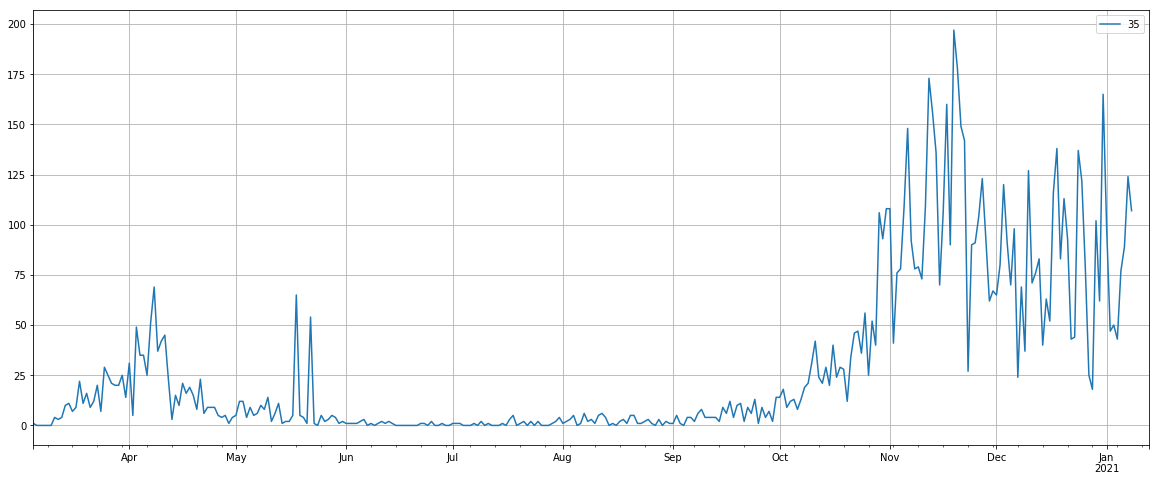

In [5]:
current_directory = os.getcwd()
parent_directory = os.path.split(current_directory)[0]
data = load_data_n_weeks(0, parent_directory + "\\preprocessedLKOS.csv", pad = 5)
data.iloc[:,35:36].plot(grid = True, figsize = (20,8))# just Osnabrrücker Land /or Stadt I think

To get demographic info and ID to name transalation

In [7]:
current_directory = os.getcwd()
parent_directory = os.path.split(current_directory)[0]

add_info_pd = pd.read_csv(parent_directory + "\\ID_to_name.csv")
additional_info = add_info_pd.to_dict("records")

demographic = add_info_pd["demographic"].to_numpy()
nl_names = add_info_pd["NL Name"].to_numpy()
#print(nl_names)

### Definitions of all features

In [12]:
def spatio_temporal_feature(times, locations):
    _times = [datetime.strptime(d, "%Y-%m-%d") for d in times]
    return np.asarray(_times).reshape((-1, 1)), np.asarray(locations).reshape((1, -1)).astype(np.float32)    

def spatio_temporal_yearly_demographics_feature(locations):
    demographic = 32289 # randomly picked an example value (GMH in 2008)
    return demographic

def temporal_polynomial_feature(t, t0, tmax, order):
    #print(order)
    t = datetime.strptime(t, "%Y-%m-%d")
    t0 = datetime.strptime(t0, "%Y-%m-%d")
    tmax = datetime.strptime(tmax, "%Y-%m-%d")

    scale = (tmax - t0).days # (pd.Datetime - pd.Datetime).days -> differenz in tagen (int)
    #print(scale)
    t_delta = (t - t0).days / scale
    #print("delta", t_delta)
    #print( "times order ", t_delta ** order)
    return t_delta ** order
#TemporalFourierFeature(SpatioTemporalFeature)

def temporal_periodic_polynomial_feature(t0, t, period, order):
    # what does period mean? 
    t = datetime.strptime(t, "%Y-%m-%d")
    t0 = datetime.strptime(t0, "%Y-%m-%d")
    tdelta = (t-t0).days % period
    return (tdelta / period) ** order
    
def temporal_sigmoid_feature(t0, t, scale):
    # what does scale do here?
    t = datetime.strptime(t, "%Y-%m-%d")
    t0 = datetime.strptime(t0, "%Y-%m-%d")
    t_delta = (t - t0) / scale
    return sp.special.expit(t_delta.days + (t_delta.seconds / (3600 * 24)))


def report_delay_polynomial_feature(t0, t, t_max, order):
    t = datetime.strptime(t, "%Y-%m-%d")
    t0 = datetime.strptime(t0, "%Y-%m-%d")
    t_max = datetime.strptime(t_max, "%Y-%m-%d")
    scale = (t_max - t0).days
    _t = 0 if t <= t0 else (t - t0).days / scale
    return _t ** order

# Never forget:
# trange: t0 to tmax
# t0: start 
# t: start nowcast
# tmax: last day foreacast

### Calculates all features

In [30]:

# what makes sense for trend_poly_order, periodic_poly_order, report_delay_order?

def features(trange, order, demographic,  include_temporal = True, include_periodic = True, 
             include_demographics = True, include_report_delay = False, trend_poly_order = 1, periodic_poly_order = 4):

    report_delay_order = order # What values make sense here??
    feature_collection = {
                "temporal_trend": {
                    "temporal_polynomial_{}".format(i): temporal_polynomial_feature(
                        trange[0], trange[1],trange[2], i
                    )
                    for i in range(trend_poly_order + 1)
                }
                if include_temporal
                else {},
                "temporal_seasonal": {
                    "temporal_periodic_polynomial_{}".format(
                        i
                ): temporal_periodic_polynomial_feature(trange[0],trange[1], 7, i) # why 7
                    for i in range(periodic_poly_order + 1)
                }
                if include_periodic
                else {},

                "temporal_report_delay": {
                    "report_delay": report_delay_polynomial_feature(
                        trange[0],trange[1], trange[2], report_delay_order # 
                    )
                }
                if include_report_delay
                else {},
                "exposure": {
                    "exposure":  demographic * 1.0 / 100000
                }
    }
    return feature_collection

# example Output

# {'temporal_trend': {'temporal_polynomial_0': 1.0, 'temporal_polynomial_1': -0.75, 'temporal_polynomial_2': 0.5625, 'temporal_polynomial_3': -0.421875}, 
# 'temporal_seasonal': {'temporal_periodic_polynomial_0': 1.0, 'temporal_periodic_polynomial_1': 0.2857142857142857, 'temporal_periodic_polynomial_2': 0.08163265306122448, 'temporal_periodic_polynomial_3': 0.02332361516034985}, 
# 'spatiotemporal': {}, 
# 'temporal_report_delay': {'report_delay': 0.014458261438686257}, 'exposure': {'exposure': 0.32289}}


In [29]:
def datetimeadaptions(date): # I don't like myself for doing this
    year = str(date)[:4] 
    month = str(date)[5:7]
    day = str(date)[8:10]
    return year+"-"+month+"-"+day

def evaluate_features(days, counties, demographic, polynom_order=3):
    # welches polynom_order ergibt Sinn?
    all_features = pd.DataFrame()
    for day in days:

        trange = [datetimeadaptions(day), datetimeadaptions(day+ pd.Timedelta(days=21)), datetimeadaptions(day+ pd.Timedelta(days=31)) ] #first train, beginn nowcast, end forecast

        for i, county in enumerate(counties):

            feature = features(trange, polynom_order, demographic[i], 
                               include_temporal = True, include_periodic = True, include_demographics = True, include_report_delay = True)
            
            feature['date'] = datetimeadaptions(day)
            feature['ID'] = county
            feature_df = pd.DataFrame.from_dict(feature)
            all_features = all_features.append(feature_df)
      
    return all_features

    

In [22]:
def get_features(target, demographics, poly_order = 3):
    
    days, counties = target.index, target.columns
    # extract features
    
    all_features = evaluate_features(days, counties, demographics,  polynom_order = poly_order)
    
    all_features.astype(float, errors = 'ignore')
    
    Y_obs = target.stack().values.astype(np.float32)
    
    len_targets = len(days) * len(counties)
    
    T_S = all_features.filter(regex = "temporal_periodic_polynomial_\d", axis = 0).dropna(axis = 1)#.values.astype(np.float32) #features["temporal_seasonal"].values.astype(np.float32)
    T_S = T_S.sort_values(["date", "ID"])
    T_S = T_S['temporal_seasonal'].to_numpy()
    T_S = T_S.reshape(len_targets, -1)
    
    T_T = all_features.filter(regex = "temporal_polynomial_\d", axis = 0).dropna(axis = 1) #features["temporal_trend"].values.astype(np.float32)
    T_T = T_T.sort_values([ "date","ID"])
    T_T = T_T["temporal_trend"].to_numpy()
    T_T = T_T.reshape(len_targets, -1)
    
    T_D = all_features.filter(regex = "report_delay", axis = 0).dropna(axis = 1) #features["temporal_report_delay"].values.astype(np.float32)
    T_D = T_D.sort_values(["date", "ID"])
    T_D = T_D["temporal_report_delay"].to_numpy()
    T_D = T_D.reshape(len_targets, -1)
    
    exposure = all_features.filter(regex = "exposure", axis = 0).dropna(axis = 1) #features["spatiotemporal"].values.astype(np.float32)
    exposure = exposure.sort_values(["date", "ID"])
    exposure = exposure["exposure"].to_numpy()
    exposure = exposure.reshape(len_targets, -1)
    
    # has to be sorted I guess? order matches the one of Y_obs =) 
    return [Y_obs, T_S, T_T, T_D, exposure]

## Default Values, mostly copied from original implementation 
(start is a semi random number)

In [23]:
 # Default Values
number_of_weeks = 3
days_into_future = 5
start = 180
start_date = pd.Timestamp("2020-03-20") + pd.Timedelta(days=start)


csv_path = parent_directory + "\\preprocessedLKOS.csv"

# do these values still make sense?
num_chains = 2 
num_cores = num_chains
trend_order = 1 # ? 
periodic_order = 4 # ??
use_report_delay = True # ?
use_demographics = True #? 
   


In [24]:
data = load_data_n_weeks(start, csv_path, pad=days_into_future)
# select two LKs to reduce computation 
data = data.iloc[:,34:36]
demographic_selection = demographic[34:36] # is loaded above


C:\Users\lkrie\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:28: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [25]:

# According to OC (Original Code) For the simple model, only targets are required 
data_train, target_train, data_test, target_test = split_data(
    data,
    train_start=start_date,
    test_start=start_date + pd.Timedelta(days=number_of_weeks * 7),
    post_test=start_date + pd.Timedelta(days=number_of_weeks * 7 + 10),
)


tspan = (target_train.index[0], target_train.index[-1])

print(target_train)

              34    35
2020-09-16   4.0   6.0
2020-09-17   7.0  12.0
2020-09-18  14.0   4.0
2020-09-19   9.0  10.0
2020-09-20   2.0  11.0
2020-09-21   8.0   2.0
2020-09-22   7.0   9.0
2020-09-23   4.0   6.0
2020-09-24   7.0  13.0
2020-09-25   6.0   1.0
2020-09-26   5.0   9.0
2020-09-27   6.0   4.0
2020-09-28   6.0   7.0
2020-09-29   4.0   2.0
2020-09-30   5.0  14.0
2020-10-01   4.0  14.0
2020-10-02   6.0  18.0
2020-10-03   2.0   9.0
2020-10-04   3.0  12.0
2020-10-05   4.0  13.0
2020-10-06   3.0   8.0


## Model Function

Excluded W_ts

In [26]:
def model(features, data):
    target = features[0]

    T_S = features[1] 
    T_T = features[2] 
    T_D = features[3] 
    exposure = features[4]
    days, counties = data.index, data.columns
    
    log_exposure = np.log(exposure).astype(np.float32).ravel()
    num_obs = np.prod(target.shape)
    num_t_s = T_S.shape[1]
    num_t_t = T_T.shape[1]
    num_t_d = T_D.shape[1]
    #num_ts = TS.shape[1]
    num_counties = len(counties)
    with pm.Model() as model:
        # priors
        # δ = 1/√α
        δ = pm.HalfCauchy("δ", 10, testval=1.0)
        α = pm.Deterministic("α", np.float32(1.0) / δ)

        W_t_s = pm.Normal(
            "W_t_s", mu=0, sd=10, testval=np.zeros(num_t_s), shape=num_t_s
        )
        W_t_t = pm.Normal(
            "W_t_t",
            mu=0,
            sd=10,
            testval=np.zeros((num_counties, num_t_t)),
            shape=(num_counties, num_t_t),
        )

        W_t_d = pm.Normal(
            "W_t_d", mu=0, sd=10, testval=np.zeros(num_t_d), shape=num_t_d
        )
#         W_ts = pm.Normal(
#             "W_ts", mu=0, sd=10, testval=np.zeros(num_ts), shape=num_ts
#         )

        param_names = ["δ", "W_t_s", "W_t_t", "W_t_d"]#, "W_ts"]
        params = [δ, W_t_s, W_t_t, W_t_d]#, W_ts]

        expanded_Wtt = tt.tile(
            W_t_t.reshape(shape=(1, num_counties, -1)), reps=(21, 1, 1)
        )
        expanded_TT = np.reshape(T_T, newshape=(21, num_counties, 2)) # was 21, num_counties, 2 (why two? Why 4? )
        result_TT = tt.flatten(tt.sum(expanded_TT * expanded_Wtt, axis=-1))

        # calculate mean rates
        μ = pm.Deterministic(
            "μ",
            tt.exp(
                tt.dot(T_S, W_t_s)
                + result_TT
                + tt.dot(T_D, W_t_d)
                #+ tt.dot(TS, W_ts)
                + log_exposure
            ),
        )
        # constrain to observations
        pm.NegativeBinomial("Y", mu=μ, alpha=α, observed=target)
    return model

### Function Sample_parameters
Changed cores to match my laptop

In [27]:
def sample_parameters(
        target,
        n_init=100,
        samples=1000, 
        chains=2,
        init="advi",
        target_accept=0.8, 
        max_treedepth=10,
        cores = 1,
        **kwargs
    ):
        """
            sample_parameters(target, samples=1000, cores=8, init="auto", **kwargs)

        Samples from the posterior parameter distribution, given a training dataset.
        The basis functions are designed to be causal, i.e. only data points strictly
        predating the predicted time points are used (this implies "one-step-ahead"-predictions).
        """

        #self.init_model(target)

        
        with model:
            # run!
            nuts = pm.step_methods.NUTS(
                #vars= params,
                target_accept=target_accept,
                max_treedepth=max_treedepth,
            )
            trace = pm.sample(
                samples,
                nuts,
                chains=chains,
                cores=cores,
                compute_convergence_checks=False,
                **kwargs
            )
        return trace

In [31]:
features_for_model = get_features(target_train, demographic_selection)
model = model(features_for_model, target_train)
trace = sample_parameters(target_train, samples=50) # samples = 50 for superficial testing

Only 50 samples in chain.
Sequential sampling (2 chains in 1 job)
NUTS: [W_t_d, W_t_t, W_t_s, δ]


Sampling 2 chains for 1_000 tune and 50 draw iterations (2_000 + 100 draws total) took 204 seconds.


Save the trace and the model 

To Do: If different models shall be saved, the names have to be adapted/naming automated

In [191]:
with open("trace", "wb") as f:
    pkl.dump(trace, f)
with open("model", "wb") as f:
    pkl.dump(model, f)

### Function sample_predictions
This was a tricky one. Averaging T_D made a lot of problems. The dimension just don't add up. Changed some thing and it's compiling but it might destroy the functionality? 

In [32]:
def sample_predictions(
    target_days_counties,
    demographics,
    parameters,
    prediction_days,
    average_periodic_feature=False,
    average_all=False,
    init="auto",
):
    

    target_days = target_days_counties.index
    
    target_counties = target_days_counties.columns
    num_counties = len(target_counties) 

    all_days = target_days.append(prediction_days)
    
    all_days_counties = pd.DataFrame(index = all_days, columns = target_counties)

    # extract features
    features_ = get_features(all_days_counties, demographics)
    target = features_[0]
    T_S = features_[1] 
    T_T = features_[2] 
    T_D = features_[3]
    exposure = features_[4]
    
    log_exposure = np.log(exposure).astype(np.float32).ravel()
 
    if average_periodic_feature:
        T_S = np.reshape(T_S, newshape=(-1, num_counties, 5))
        mean = np.mean(T_S, axis=0, keepdims=True)
        T_S = np.reshape(np.tile(mean, reps=(T_S.shape[0], 1, 1)), (-1, 5))


    if average_all:
        T_S = np.reshape(T_S, newshape=(31, num_counties, -1))
        mean = np.mean(T_S, axis=0, keepdims=True)
        T_S = np.reshape(np.tile(mean, reps=(31, 1, 1)), (-1, 5))
        
        #print("T_D ohne reshape:", T_D.shape)
        T_D = np.reshape(T_D, newshape=(31, num_counties, -1))
        #print("T_D erstes reshape:", T_D.shape)
        mean = np.mean(T_D, axis=0, keepdims=True)
        #print("Mean", mean.shape)
        T_D = np.reshape(np.tile(mean, reps=(31, 1)), newshape=(-1,1)) 
        
        # What it used to be. But those damn dimensions don't add up. Even without the hard coded LKs
#         T_D = np.reshape(T_D, newshape=(31, 412, -1))
#         mean = np.mean(T_D, axis=0, keepdims=True)
#         T_D = np.reshape(np.tile(mean, reps=(31, 1, 1)), (-1))
        
        log_exposure = np.reshape(log_exposure, newshape=(31, num_counties))
        mean = np.mean(log_exposure, axis=0, keepdims=True)
        log_exposure = np.reshape(np.tile(mean, reps=(31, 1,1)), (-1))
  
    # extract coefficient samples
    α = parameters["α"]
    W_t_s = parameters["W_t_s"]
    W_t_t = parameters["W_t_t"]
    W_t_d = parameters["W_t_d"]
    #W_ts = parameters["W_ts"]

   
    num_predictions = len(target_days) * len(target_counties) + len(
        prediction_days
    ) * len(target_counties)
    num_parameter_samples = α.size
    
    y = np.zeros((num_parameter_samples, num_predictions), dtype=int)
    μ = np.zeros((num_parameter_samples, num_predictions), dtype=np.float32)

    expanded_Wtt = np.tile(
        np.reshape(W_t_t, newshape=(-1, 1, num_counties, 2)), reps=(1, 31, 1, 1)
    )

    expanded_TT = np.reshape(T_T, newshape=(1, 31, num_counties, 2))
    result_TT = np.reshape(
        np.sum(expanded_TT * expanded_Wtt, axis=-1), newshape=(-1, 31 * num_counties)
    )

    # NOTE: the delay polynomial is left out here!
    # mean_delay /= num_parameter_samples

    
    for i in range(num_parameter_samples):
        print(i, "/", num_parameter_samples) # takes a lot of time, this way one can kind of monitor if it got stuck
        μ[i, :] = np.exp( #why exp?
            np.dot(T_S, W_t_s[i]) # passt
            + result_TT[i] # passt
            + np.dot(T_D, W_t_d[i]) 
            + log_exposure # passt
        )

        y[i, :] = pm.NegativeBinomial.dist(mu=μ[i, :], alpha=α[i]).random()
    print("y", y, "μ", μ, "α", α)
    return {"y": y, "μ": μ, "α": α}

In [33]:
pred = sample_predictions(
        target_train,
        demographic_selection, 
        trace,
        target_test.index,
        average_periodic_feature=False,
        average_all=False,
    )

0 / 100
1 / 100
2 / 100
3 / 100
4 / 100
5 / 100
6 / 100
7 / 100
8 / 100


KeyboardInterrupt: 

In [193]:
pred_trend = sample_predictions(
    target_train,
    demographic_selection,
    trace,
    target_test.index,
    average_periodic_feature=False,
    average_all=True,
)

INFO (theano.gof.compilelock): Refreshing lock C:\Users\lkrie\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_69_Stepping_1_GenuineIntel-3.7.9-64\lock_dir\lock



 T_D zweites reshape: (62, 1)
0 / 100
[4.837455 7.50864  4.837455 7.50864  4.837455 7.50864  4.837455 7.50864
 4.837455 7.50864  4.837455 7.50864  4.837455 7.50864  4.837455 7.50864
 4.837455 7.50864  4.837455 7.50864  4.837455 7.50864  4.837455 7.50864
 4.837455 7.50864  4.837455 7.50864  4.837455 7.50864  4.837455 7.50864
 4.837455 7.50864  4.837455 7.50864  4.837455 7.50864  4.837455 7.50864
 4.837455 7.50864  4.837455 7.50864  4.837455 7.50864  4.837455 7.50864
 4.837455 7.50864  4.837455 7.50864  4.837455 7.50864  4.837455 7.50864
 4.837455 7.50864  4.837455 7.50864  4.837455 7.50864 ]
1 / 100
[5.6650105 8.027423  5.6650105 8.027423  5.6650105 8.027423  5.6650105
 8.027423  5.6650105 8.027423  5.6650105 8.027423  5.6650105 8.027423
 5.6650105 8.027423  5.6650105 8.027423  5.6650105 8.027423  5.6650105
 8.027423  5.6650105 8.027423  5.6650105 8.027423  5.6650105 8.027423
 5.6650105 8.027423  5.6650105 8.027423  5.6650105 8.027423  5.6650105
 8.027423  5.6650105 8.027423  5.6650105

INFO (theano.gof.compilelock): Refreshing lock C:\Users\lkrie\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_69_Stepping_1_GenuineIntel-3.7.9-64\lock_dir\lock


36 / 100
[6.382846 8.838478 6.382846 8.838478 6.382846 8.838478 6.382846 8.838478
 6.382846 8.838478 6.382846 8.838478 6.382846 8.838478 6.382846 8.838478
 6.382846 8.838478 6.382846 8.838478 6.382846 8.838478 6.382846 8.838478
 6.382846 8.838478 6.382846 8.838478 6.382846 8.838478 6.382846 8.838478
 6.382846 8.838478 6.382846 8.838478 6.382846 8.838478 6.382846 8.838478
 6.382846 8.838478 6.382846 8.838478 6.382846 8.838478 6.382846 8.838478
 6.382846 8.838478 6.382846 8.838478 6.382846 8.838478 6.382846 8.838478
 6.382846 8.838478 6.382846 8.838478 6.382846 8.838478]
37 / 100
[4.5121226 9.137923  4.5121226 9.137923  4.5121226 9.137923  4.5121226
 9.137923  4.5121226 9.137923  4.5121226 9.137923  4.5121226 9.137923
 4.5121226 9.137923  4.5121226 9.137923  4.5121226 9.137923  4.5121226
 9.137923  4.5121226 9.137923  4.5121226 9.137923  4.5121226 9.137923
 4.5121226 9.137923  4.5121226 9.137923  4.5121226 9.137923  4.5121226
 9.137923  4.5121226 9.137923  4.5121226 9.137923  4.5121226 9

INFO (theano.gof.compilelock): Refreshing lock C:\Users\lkrie\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_69_Stepping_1_GenuineIntel-3.7.9-64\lock_dir\lock


74 / 100
[4.811733 8.353381 4.811733 8.353381 4.811733 8.353381 4.811733 8.353381
 4.811733 8.353381 4.811733 8.353381 4.811733 8.353381 4.811733 8.353381
 4.811733 8.353381 4.811733 8.353381 4.811733 8.353381 4.811733 8.353381
 4.811733 8.353381 4.811733 8.353381 4.811733 8.353381 4.811733 8.353381
 4.811733 8.353381 4.811733 8.353381 4.811733 8.353381 4.811733 8.353381
 4.811733 8.353381 4.811733 8.353381 4.811733 8.353381 4.811733 8.353381
 4.811733 8.353381 4.811733 8.353381 4.811733 8.353381 4.811733 8.353381
 4.811733 8.353381 4.811733 8.353381 4.811733 8.353381]
75 / 100
[6.458002  7.9371696 6.458002  7.9371696 6.458002  7.9371696 6.458002
 7.9371696 6.458002  7.9371696 6.458002  7.9371696 6.458002  7.9371696
 6.458002  7.9371696 6.458002  7.9371696 6.458002  7.9371696 6.458002
 7.9371696 6.458002  7.9371696 6.458002  7.9371696 6.458002  7.9371696
 6.458002  7.9371696 6.458002  7.9371696 6.458002  7.9371696 6.458002
 7.9371696 6.458002  7.9371696 6.458002  7.9371696 6.458002  7.

### Save the predictions and predictions_trend

In [194]:
with open("predictions", "wb") as f:
    pkl.dump(pred, f)
with open("predictions_trend", "wb") as f:
    pkl.dump(pred_trend, f)

### Some preliminary plottig to see some results

C:\Users\lkrie\AppData\Roaming\Python\Python37\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\Users\lkrie\AppData\Roaming\Python\Python37\site-packages\arviz\plots\traceplot.py:195: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (31), generating only 20 plots
  UserWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C3A7989888>,
      dtype=object)

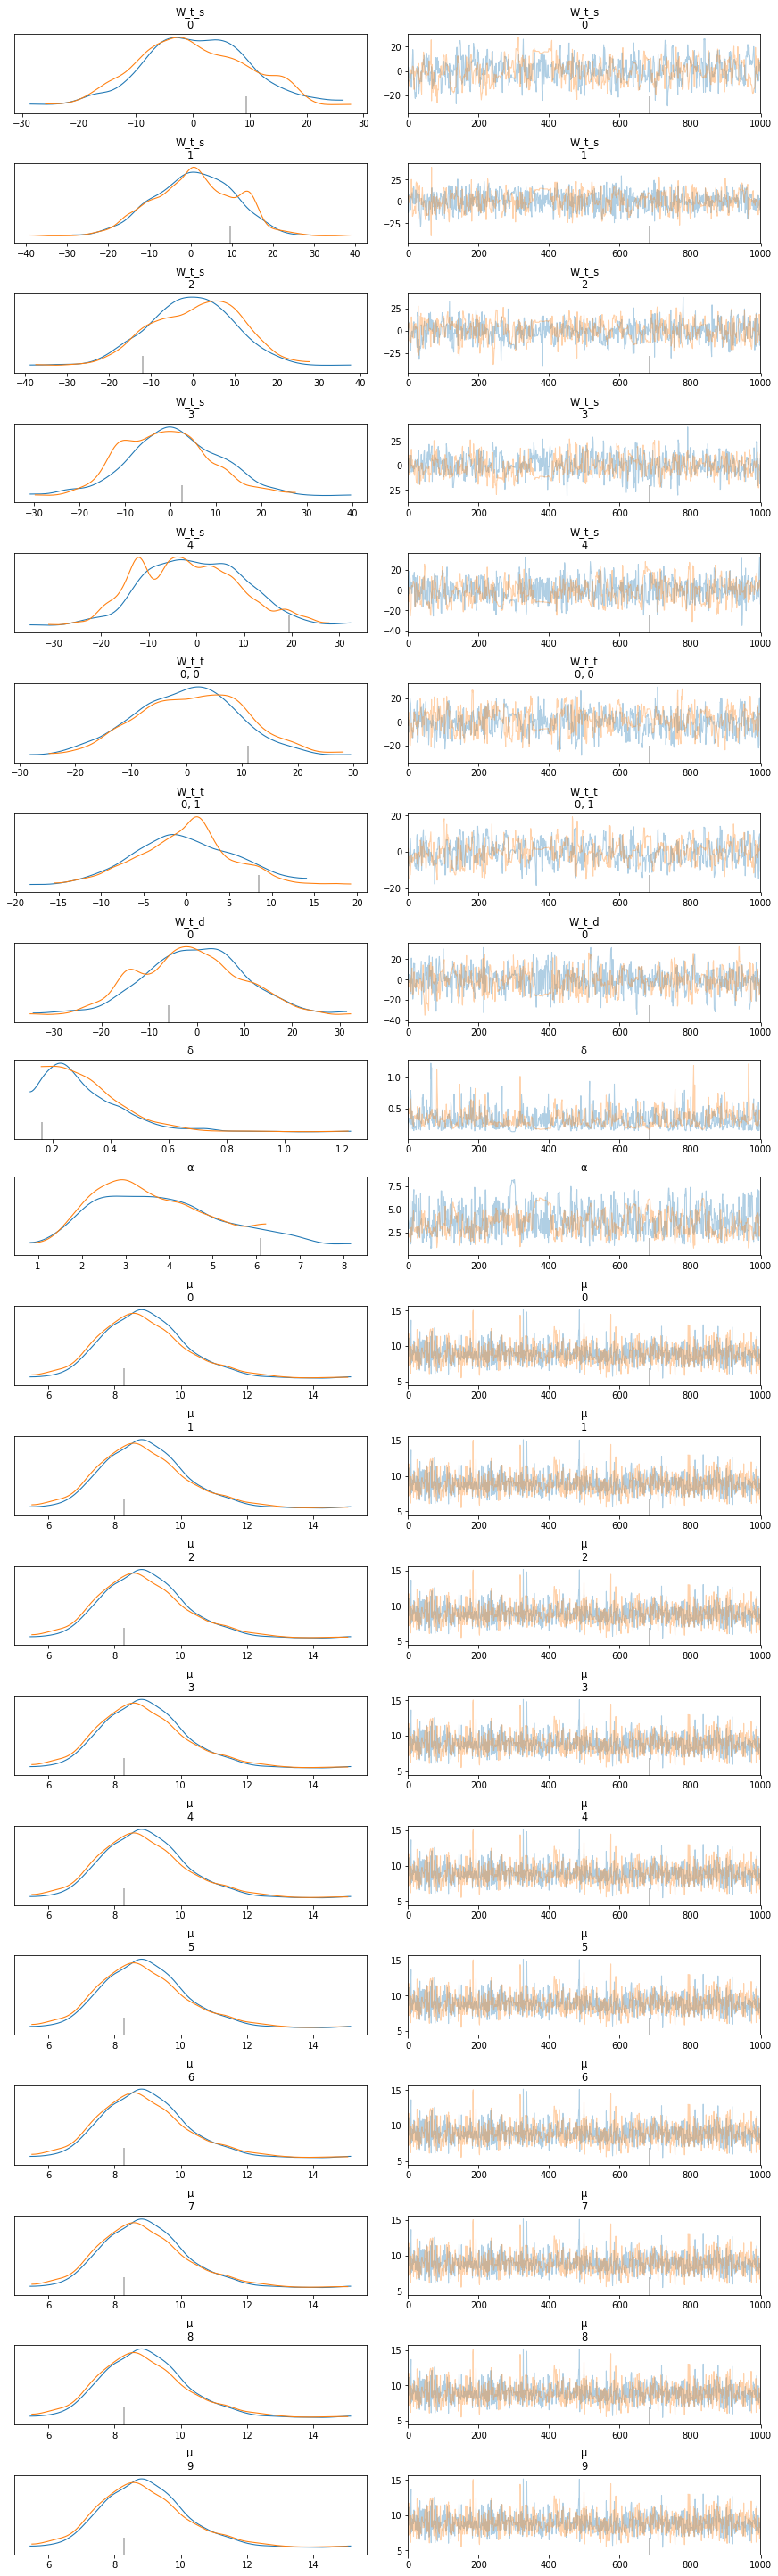

In [140]:
az.plot_trace(trace)

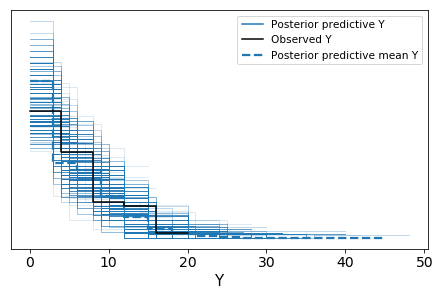

In [89]:
with model:
    ppc = pm.sample_posterior_predictive(
        trace    )
# "δ", "W_t_s", "W_t_t", "W_t_d"
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model));


In [22]:
np.exp(az.summary(trace)[["mean", "hdi_3%", "hdi_97%"]])

C:\Users\lkrie\AppData\Roaming\Python\Python37\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,hdi_3%,hdi_97%
W_t_s[0],0.972388,8.587141e-09,2.891873e+07
"W_t_t[0,0]",2.155451,5.466731e-08,6.875087e+07
"W_t_t[0,1]",0.905743,3.472676e-05,2.618652e+04
W_t_d[0],0.840297,4.887499e-08,7.689874e+07
δ,1.378506,1.119632e+00,1.820298e+00
α,42.393710,3.636421e+00,7.119445e+02
μ[0],7115.280973,6.220373e+02,6.894056e+04
μ[1],7115.280973,6.220373e+02,6.894056e+04
μ[2],7115.280973,6.220373e+02,6.894056e+04
μ[3],7115.280973,6.220373e+02,6.894056e+04
